# Les séries temporelles avec Python (4/4)

>1. Introduction à la manipulation de données temporelles avec Python
>2. Visualisation et opérations sur les séries temporelles
>3. Éléments théoriques et exemples
>4. **Analyse, modélisation et prédiction**

Ce 4ème et dernier post sur les séries temporelles présente les méthodes d'analyse, de modélisation et de prédiction des séries temporelles. Nous y verrons notamment la décomposition d'une série temporelle, le lissage non pas brésilien mais exponentiel, les modèles classiques que sont les ARIMA et SARIMA (puis peut-être pour finir une petite ouverture sur des modèles plus récents, Prophet LSTM etc...)

# Analyse, modélisation et prédiction

Où l'on va discuter encore d'autres trucs sur les séries temporelles.

## Décomposition d'une série temporelle

Le principe de la décomposition des séries temporelles est de découper les séries originales en plusieurs composants indépendants (qu'on a vus plus haut) : tendance, saisonnalité, cycle et bruit.

Pour illustrer tout ça, on va utiliser des données qui sont aux séries temporelles ce que le dataset "Titanic" est au machine learning, la base : la série AirPassenger qui mesure le nombre mensuel de passagers aériens, en milliers, de janvier 1949 à décembre 1960.

Dans la suite, on va noter $X_t$  la série AirPassengers et $Y_t=ln(X_t)$. 

**Exo :** pour commencer, charger le dataset et afficher simplement la série (sans utiliser la fonction `ts_plot`) puis afficher aussi la série logarithmique. Commenter les résultats.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fonctions as fct

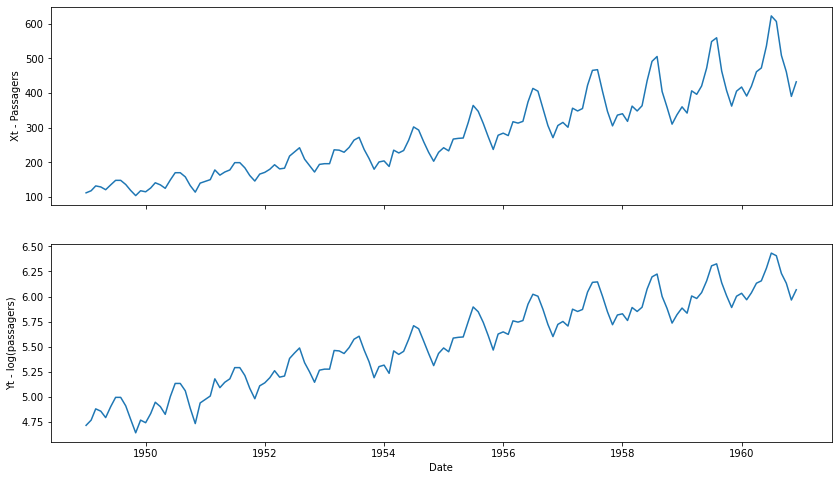

In [12]:
df = pd.read_csv('data/AirPassengers.csv', header=0, index_col=0, parse_dates=True)
df.index.freq = 'MS' #pour spécifier la fréquence, c'est ensuite utile pour la prédiction
# ou pd.infer_freq(df.index) qui ne nécessite pas de connaître la fréquence au préalable

x = df['Airpass']
y = np.log(x)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8), sharex=True)
ax1.plot(x)
ax1.set_ylabel('Xt - Passagers')

ax2.plot(y)
ax2.set_ylabel('Yt - log(passagers)')
ax2.set_xlabel('Date')
plt.show()

On voit un accroissement de la saisonnalité dans la série $X_t$ qui disparait lorsqu'on applique la transformation logarithmique.  
Pour rappel, une des propriété fondamentale du $log$ est que $log(ab)=log(a)+log(b)$.  
On passe ainsi d’un modèle **multiplicatif** à un modèle **additif**.
On va bosser sur la série logarithmique plutôt car linéaire.

### La tendance

On l'a vu un dans le notebook d'intro, une façon d'identifier la tendance consiste à lisser la courbe en utilisant des moyennes mobiles sur une fenêtre glissante d'observations.

**Exo :** faire une figure avec plusieurs graphiques, chacun représentant 2 séries : la série originale et la série des moyennes mobiles pour différentes longueur de fenêtres glissantes. Commenter les résultats

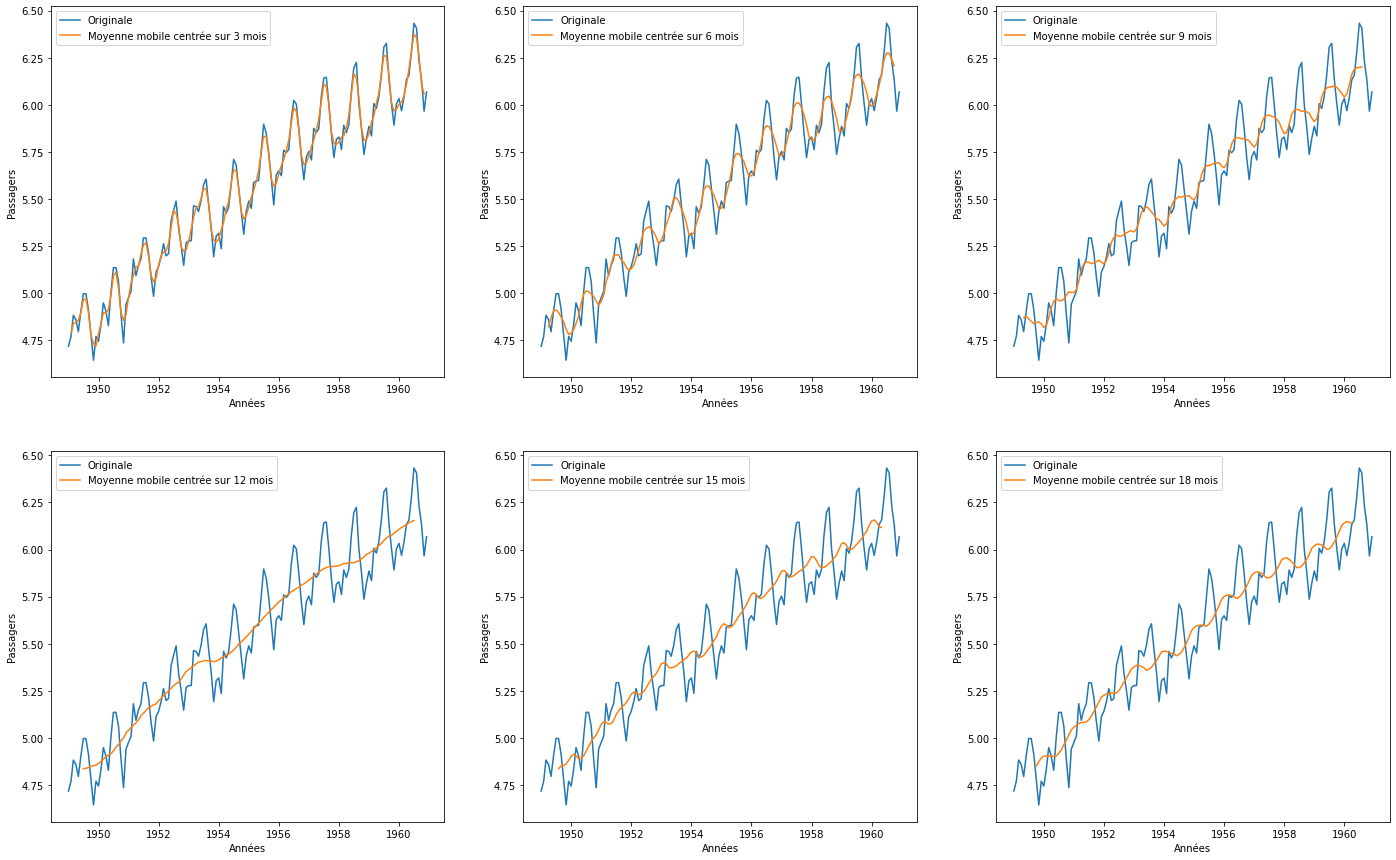

In [13]:
fig = plt.figure(figsize=(24,15));

fenetres = [3,6,9,12,15,18]
for i in range(6):
    ax = fig.add_subplot(2,3,i+1)
    ax.plot(y.index, y, label='Originale');
    ax.plot(y.index, y.rolling(fenetres[i], center=True).mean(), label=f'Moyenne mobile centrée sur {fenetres[i]} mois');
    ax.set_xlabel("Années");
    ax.set_ylabel("Passagers");
    ax.legend(loc='best');

### Saisonnalité

Une manière de vérifier l'effet saisonnier est de tracer une courbe pour chaque année en prenant les mois comme abscisses et visualiser ainsi la répartition des passagers au cours de chaque année.

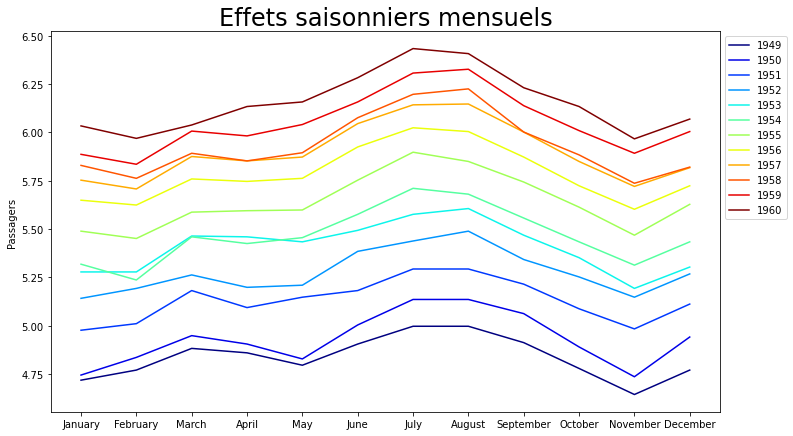

In [14]:
plt.figure(figsize=(12,7))

yrs = [str(yr) for yr in y.index.year.unique()]
colors = plt.cm.jet(np.linspace(0,1,len(yrs)))

for i in range(len(yrs)):
    plt.plot(y.index.month_name().unique(), y[yrs[i]], label=yrs[i], color=colors[i])
    plt.legend(loc='best', bbox_to_anchor=(1,1))
    plt.title('Effets saisonniers mensuels', fontsize=24)
    plt.ylabel('Passagers')

### Bruit

**Exo :** utiliser la fonction `seasonal_decompose` qui renvoie la série temporelle d'origine, la tendance, la saisonnalité et les résidus

<Figure size 1008x1152 with 0 Axes>

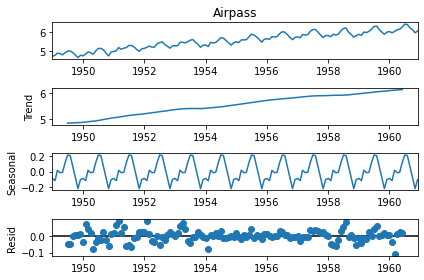

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(14,16))
decomp = seasonal_decompose(y, model='additive')
decomp.plot();

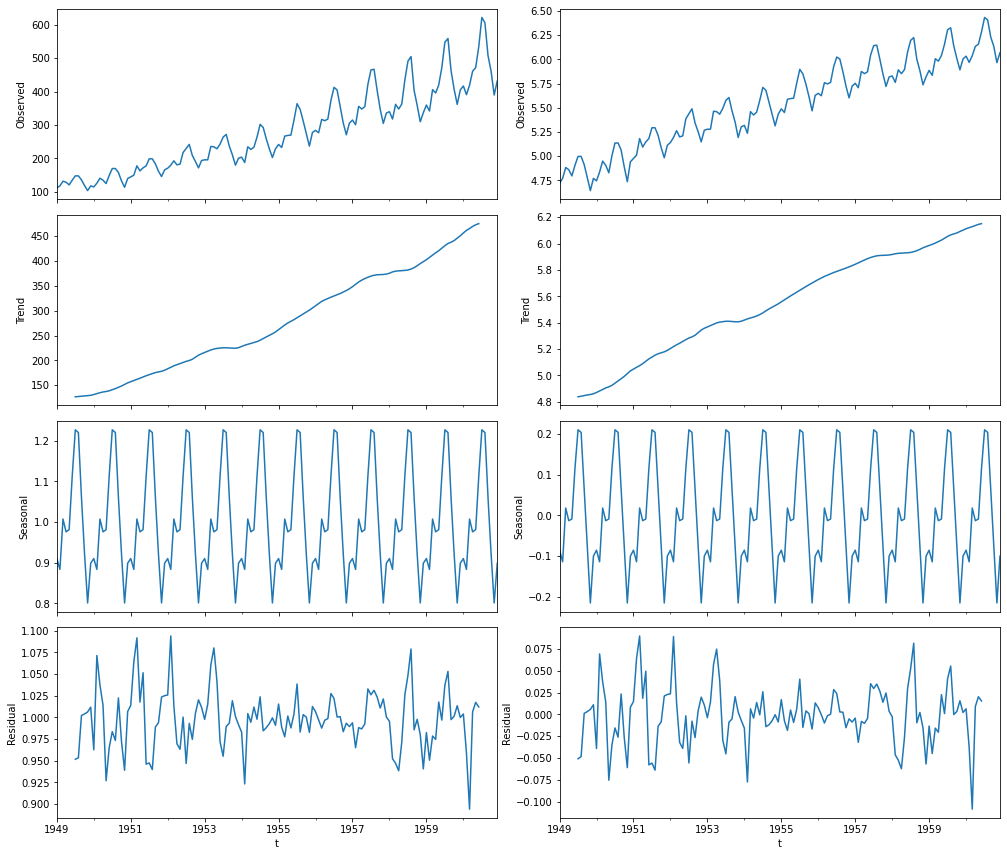

In [16]:
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(14,12))

fct.plotseasonal(seasonal_decompose(x, model='multiplicative'), axes[:,0])
fct.plotseasonal(seasonal_decompose(y, model='additive'), axes[:,1])

plt.tight_layout()
plt.show()

## Prévision avec un lissage exponentiel

Le lisage exponentiel est une technique de lissage qui ressemble un peu aux moyennes mobiles et peut être utilisée pour prédire une série temporelle. C'est en fait un cas particulier des modèles ARMA déjà évoqués. On en distingue différents types (simple, double, triple...). On notera que les lissages exponentiels simple et double ne sont plus vraiment d'actualité. En revanche le lissage exponentiel triple, lui, est parfois utilisé.

Pour un lissage exponentiel simple (qui ne sera pas efficace ici puiqu'il s'applique sur une série sans saisonnalité et à tendance localement constante), on peut faire :

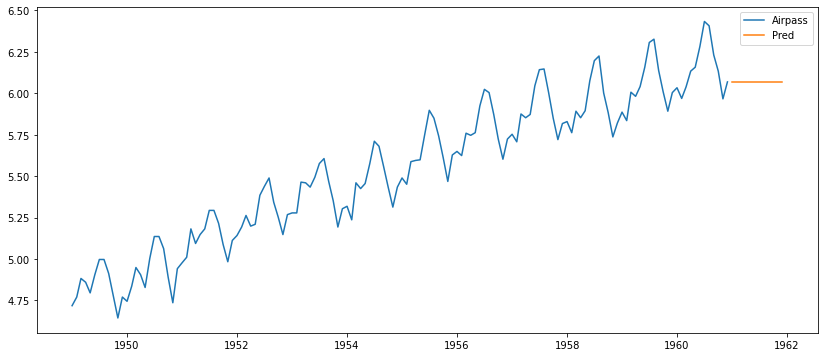

In [17]:
from statsmodels.tsa.api import ExponentialSmoothing

les = ExponentialSmoothing(y.values, trend=None, seasonal=None).fit()
les_pred = les.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(y, label='Airpass')
plt.plot(pd.date_range(y.index[-1], periods=12, freq='M'), les_pred, label='Pred')
plt.legend()
plt.show()

Pour le lissage exponentiel double (adapté pour des séries à tendance localement linéaire) :

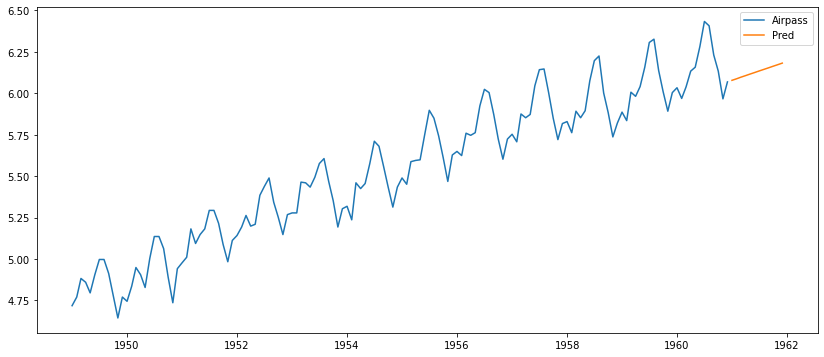

In [18]:
led = ExponentialSmoothing(y.values, trend='add', seasonal=None).fit()
led_pred = led.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(y, label='Airpass')
plt.plot(pd.date_range(y.index[-1], periods=12, freq='M'), led_pred, label='Pred')
plt.legend()
plt.show()

Pour le lissage exponentiel triple ou méthode de Holt-Winters (prise en compte en plus d'une composante saisonnière) :

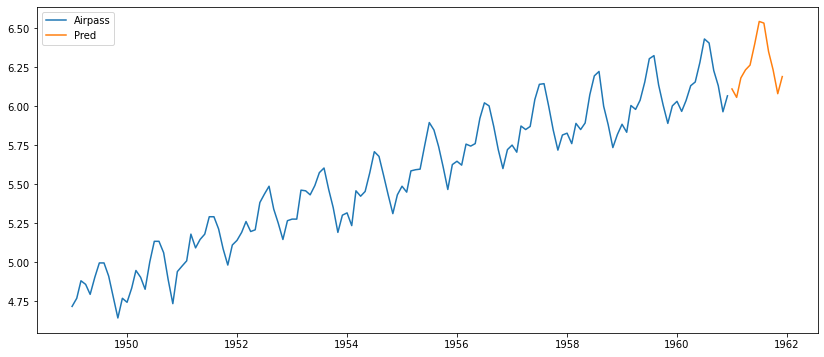

In [19]:
let = ExponentialSmoothing(y.values, seasonal_periods=12, trend='add', seasonal='add').fit()
let_pred = let.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(y, label='Airpass')
plt.plot(pd.date_range(y.index[-1], periods=12, freq='M'), let_pred, label='Pred')
plt.legend()
plt.show()

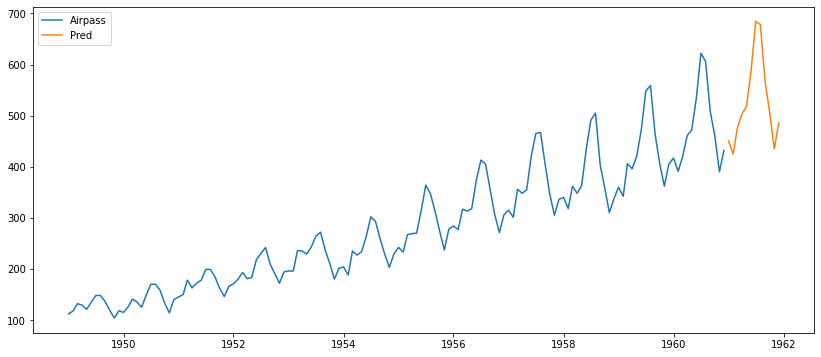

In [20]:
let = ExponentialSmoothing(x.values, seasonal_periods=12, trend='mul', seasonal='mul').fit()
let_pred = let.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(x, label='Airpass')
plt.plot(pd.date_range(x.index[-1], periods=12, freq='M'), let_pred, label='Pred')
plt.legend()
plt.show()

## Prévision à l'aide d'un modèle ARIMA

Un modèle autoréfressif intégré à moyennes mobiles (ARIMA) est une généralisation du modèle ARMA, aperçu plus haut. 

Les modèles ARIMA sont appliqués dans certains cas où les données montrent une non-stationnarité, où une étape de différenciation initiale (correspondant à la partie "intégrée" du modèle) peut être appliquée une ou plusieurs fois pour éliminer la non-stationnarité.

Dans le modèle de base, trois paramètres $(p,d,q)$ sont utilisés pour paramétrer les modèles ARIMA. Par conséquent, un modèle ARIMA est noté $ARIMA(p,d,q)$ et est défini par :
$$
\left(1 - \sum_{i=1}^p \phi_i L^i \right) (1 - L)^d y_t = \mu + \left(1 + \sum_{i=1}^q \theta_i L^i \right) \varepsilon_t
$$

Une généralisation est le modèle SARIMA, ou ARIMA saisonnier, qui permet de tenir compte en plus de la saisonnalité. Ce modèle est caractérisé non plus par 3 paramètres $(p,d,q)$ mais par 7 ! Le modèle SARIMA noté $SARIMA(p,d,q)(P,D,Q)_s$ où :
- $s$ est la période de la saisonnalité
- $(P,D,Q)$ sont les ordres de la partie saisonnière

On va essayer de pas trop rentrer dans les détails théoriques mais de voir par la pratique.

### Stationnarisation de la série

Les séries ont généralement une tendance et une saisonnalité. Pour pouvoir les modéliser par des processus stationnaires comme les ARMA, il faut les stationnariser. On va voir en pratique comment faire.

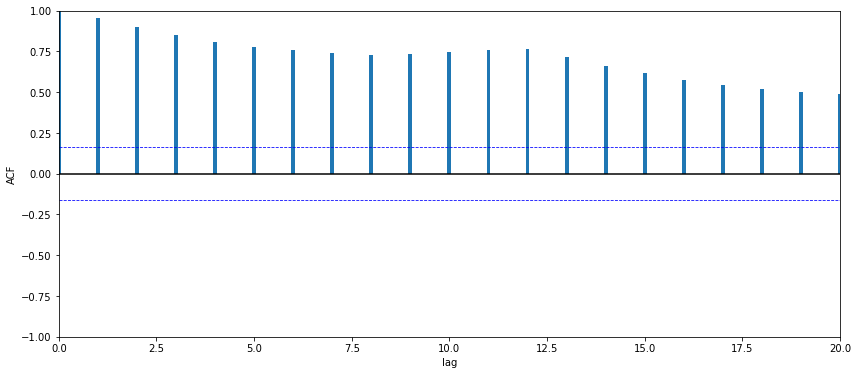

In [21]:
fct.plot_acf_pacf(y)

La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. On effectue donc une différenciation $(1-L)$ c'est-à-dire qu'on va regarder la série $Y_t-Y_{t-1}$.

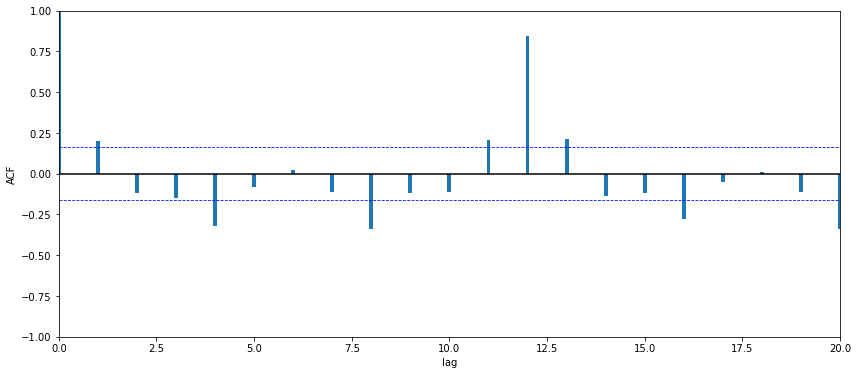

In [22]:
y_diff_1 = y - y.shift(1)
fct.plot_acf_pacf(y_diff_1[1:])

Toujours une décroissance lente vers 0 de la série différenciée d'ordre 1 **pour les multiples de 12**. Cela correspond à la saisonnalité et on va donc différencier à nouveau en appliquant cette fois $(1-L^{12})$ .

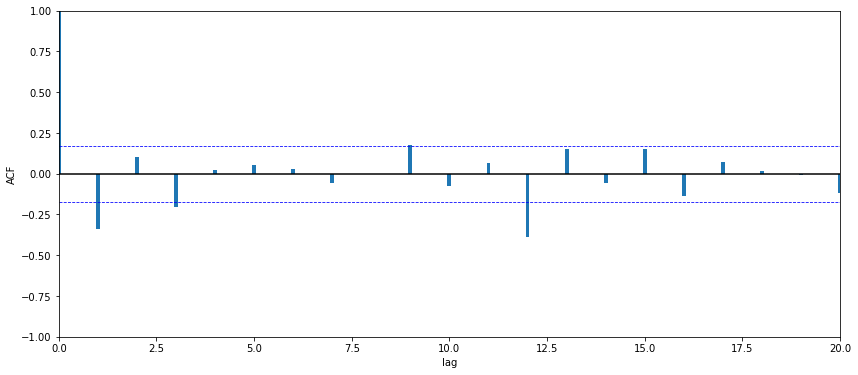

In [23]:
y_diff_1_12 = y_diff_1 - y_diff_1.shift(12)
fct.plot_acf_pacf(y_diff_1_12[13:])

Avec cette double différenciation, on s'approche d'un autocorrélogramme simple empirique. On va donc modéliser la série $(1-L)(1-L^{12})ln(X_t)$ par un modèle ARMA.

### Identification, estimation et validation de modèles

On va s'appuyer sur les sorties ACF et PACF donc on peut utiliser une des fonctions disponibles dans `fonctions.py` par exemple `ts_plot` pour changer.

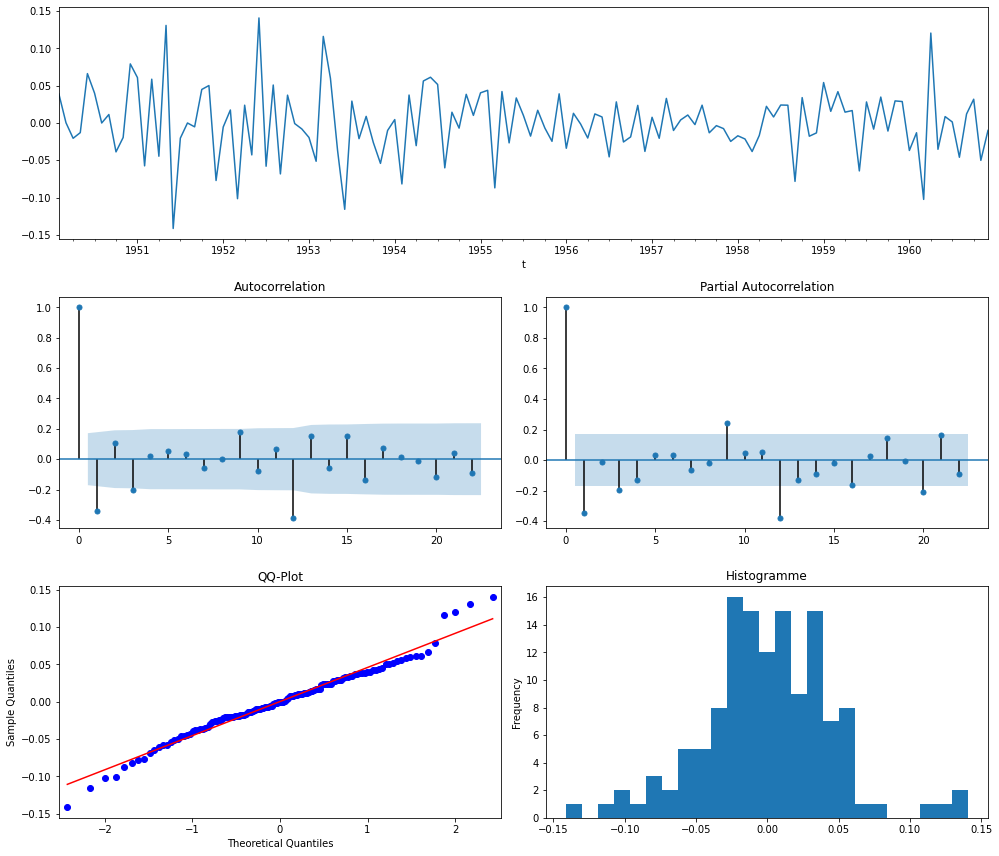

In [24]:
fct.ts_plot(y_diff_1_12[13:])

Les graphiques ACF et PACF permettent de voir empiriquement qu'on va avoir un modèle $SARIMA(p,d,q)(P,D,Q)_s$ avec $s=12$. On va tester différents modèles.

**Modèle 1 :** pour commencer on va prendre un $SARIMA(1,1,1)(1,1,1)_{12}$ qui s'écrit :
$$(1-\phi_{1}L)(1-\phi'_{1}L^{12})(1-L)(1-L^{12})ln(X_{t})=(1+\theta_{1}L)(1+\theta'_{1}L^{12})\epsilon_{t} $$

In [25]:
from statsmodels.tsa.statespace.sarimax import *

m1 = SARIMAX(y.values, order=(1,1,1), seasonal_order=(1,1,1,12))
res1 = m1.fit()
print(res1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.152
Date:                            Tue, 09 Jun 2020   AIC                           -480.303
Time:                                    11:36:06   BIC                           -465.927
Sample:                                         0   HQIC                          -474.462
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1641      0.213      0.772      0.440      -0.252       0.581
ma.L1         -0.5600      0.184   

Ce modèle a des coefficients non significatifs, on en teste un second en retirant dans le paramètre associé à la plus grande p-value : ici c'est le terme autorégressif saisonnier.

**Modèle 2 :** on va donc prendre un $SARIMA(1,1,1)(0,1,1)_{12}$ qui s'écrit :
$$(1-\phi_{1}L)(1-L)(1-L^{12})ln(X_{t})=(1+\theta_{1}L)(1+\theta'_{1}L^{12})\epsilon_{t} $$

In [26]:
m2 = SARIMAX(y.values, order=(1,1,1), seasonal_order=(0,1,1,12))
res2 = m2.fit()
print(res2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.946
Date:                            Tue, 09 Jun 2020   AIC                           -481.893
Time:                                    11:36:06   BIC                           -470.392
Sample:                                         0   HQIC                          -477.220
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1946      0.199      0.977      0.329      -0.196       0.585
ma.L1         -0.5772      0.172   

Ce modèle a toujours un coefficient non significatif, on en teste un 3ème modèle en retirant dans le terme autorégressif d'ordre 1.

**Modèle 3 :** on va donc prendre un $SARIMA(0,1,1)(0,1,1)_{12}$ qui s'écrit :
$$(1-L)(1-L^{12})ln(X_{t})=(1+\theta_{1}L)(1+\theta'_{1}L^{12})\epsilon_{t} $$

In [27]:
m3 = SARIMAX(y.values, order=(0,1,1), seasonal_order=(0,1,1,12))
res3 = m3.fit()
print(res3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Tue, 09 Jun 2020   AIC                           -483.393
Time:                                    11:36:07   BIC                           -474.767
Sample:                                         0   HQIC                          -479.888
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4018      0.073     -5.503      0.000      -0.545      -0.259
ma.S.L12      -0.5571      0.096   

Cette fois tous les coefficients sont significatifs, il faut encore tester ce qu'on appelle la "blancheur" des résidus : on veut avoir des résidus qui sont un bruit blanc (faible), c'est-à-dire, entre autres qu'ils sont non corrélés.  
Pour ça on peut utiliser le test de Ljung-Box d'autocorrélation des résidus qui est implémenté dans la fonction `acorr_ljungbox` de `statsmodels.stats.diagnostic` 

In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print('Retard : p-value')
for lag in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(lag, acorr_ljungbox(res3.resid, lags=lag, return_df=False)[1].mean()))

Retard : p-value
6 : 0.9817270269364117
12 : 0.9083095873910859
18 : 0.6207424949666911
24 : 0.5187401717056269
30 : 0.5161865655961687
36 : 0.5604027554014362


Toutes les p-values sont élevées ce qui signifie qu'on ne peut pas rejeter l'hypothèse nulle du test. Or, l'hypothèse $H_0$ est qu'il n'y a pas d'autocorrélation des résidus, on peut pas la rejeter, donc on est bon !

On peut enfin tester la normalité des résidus avec le test de Shapiro-Wilk implémenté dans la fonction `scipy.stats.shapiro`, l'hypothèse nulle étant que les étant que les observations sont normalement distribuées, on souhaite encore une fois une p-value élevée pour ne pas rejeter $H_0$.

In [29]:
from scipy.stats import shapiro
shapiro(res3.resid[13:])

(0.9908453822135925, 0.5469879508018494)

Le test de normalité est également validé pour ce modèle et on peut afficher les résidus pour le visualiser :

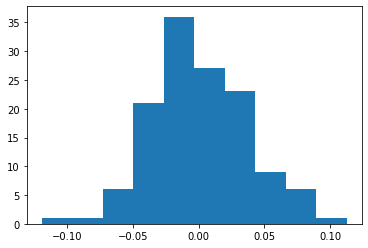

In [30]:
plt.hist(res3.resid[13:], bins=10);

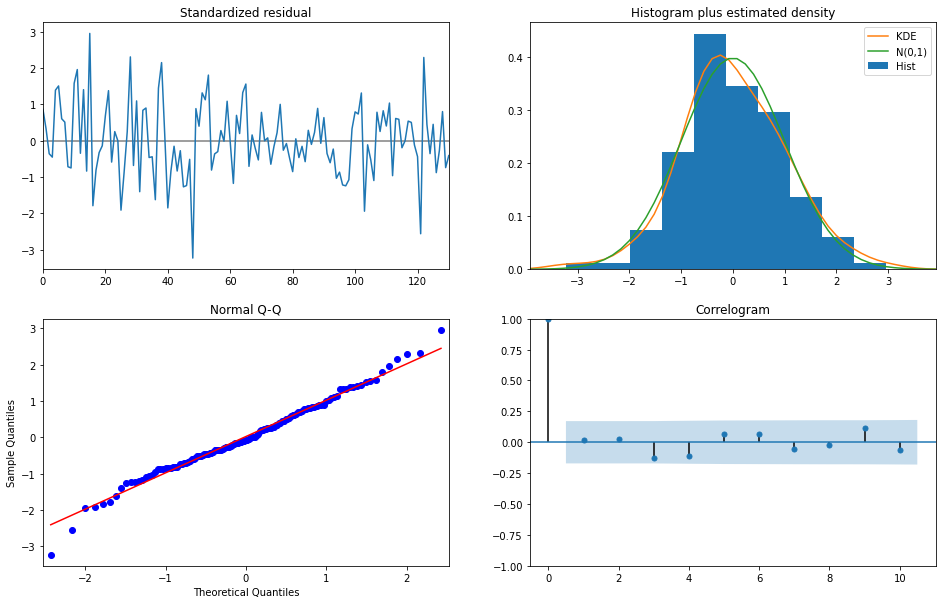

In [31]:
# autre méthode d'affichage des résultats
# attention, ce sont les résidus standardisés par contre donc pas exactement les mêmes que ceux affichés au dessus.
res3.plot_diagnostics(figsize=(16, 10));

### Prévision de l’année 1961 avec le modèle retenu

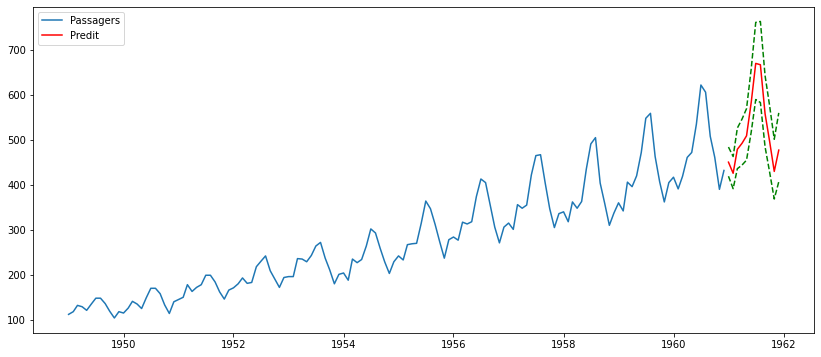

In [32]:
# prédiction et intervalles de confiance
y_pred = res3.get_forecast(12)
x_pred = np.exp(y_pred.predicted_mean)
x_pred_inf = [np.exp(p[0]) for p in y_pred.conf_int(alpha=0.05)]
x_pred_sup = [np.exp(p[1]) for p in y_pred.conf_int(alpha=0.05)]

# affichage
plt.figure(figsize=(14,6))
plt.plot(x.index, x.values, label='Passagers')
plt.plot(pd.date_range(x.index[-1], periods=12, freq='M'), x_pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[-1], periods=12, freq='M'), x_pred_inf, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[-1], periods=12, freq='M'), x_pred_sup, color='g', linestyle='--')
plt.legend()
plt.show()

### Évaluation de la qualité prédictive du modèle

On a pas eu vraiment besoin de le faire jusqu'à maintenant mais, vous le savez, pour pouvoir faire un modèle prédictif, il faut mettre en place, entraîner, tester et évaluer votre modèle. Pour cela, il faut découper nos données en training et test sets.

**Exo :** splitter en training et test sets en tronquant la série en 1959 pour pouvoir ensuite prédire l'année 1960

In [33]:
# on fait pas un train_test_split mais on tronque la série car on veut pas des valeurs réparties aléatoirement :
# on veut tous les points jusqu'à une certaine date pour prédire ceux qui suivent

# série x : série des passagers
x_train = x[:'1959']
x_test = x['1960':]

# série y=log(x) : transformation logarithmique de la série des passagers 
y_train = y[:'1959']
y_test = y['1960':]

**Exo :** vérifier que le modèle retenu précédemment est toujours valide sur la série tronquée "y_train"

In [36]:
# modélisation et summary
model = SARIMAX(y_train.values, order=(0,1,1), seasonal_order=(0,1,1,12))
res = model.fit()
print(res.summary())

# test d'autocorrélation des résidus
print('Retard : p-value')
for lag in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(lag, acorr_ljungbox(res.resid, lags=lag, return_df=False)[1].mean()))
    
# test de normalité des résidus
shapiro(res.resid[13:])

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 223.627
Date:                            Tue, 09 Jun 2020   AIC                           -441.253
Time:                                    11:46:16   BIC                           -432.916
Sample:                                         0   HQIC                          -437.868
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3485      0.081     -4.302      0.000      -0.507      -0.190
ma.S.L12      -0.5623      0.094   

(0.9925811290740967, 0.7795132994651794)

**Exo :** prédire les valeurs des années 1959 et 1960 et afficher sur un même graphique les valeurs réelles, prédites et les intervalles de confiance

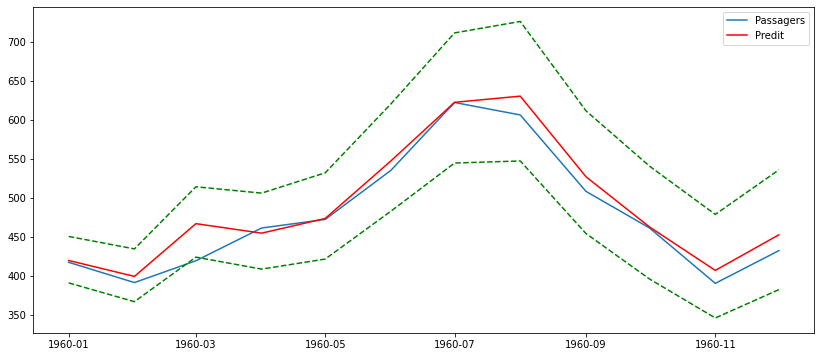

In [37]:
# prédiction et intervalles de confiance
y_pred = res.get_forecast(len(y_test))
x_pred = np.exp(y_pred.predicted_mean)
x_pred_inf = [np.exp(p[0]) for p in y_pred.conf_int(alpha=0.05)]
x_pred_sup = [np.exp(p[1]) for p in y_pred.conf_int(alpha=0.05)]

# affichage
plt.figure(figsize=(14,6))
plt.plot(x_test.index, x_test.values, label='Passagers')
plt.plot(x_test.index, x_pred, color='r', label='Predit')
plt.plot(x_test.index, x_pred_inf, color='g', linestyle='--')
plt.plot(x_test.index, x_pred_sup, color='g', linestyle='--')
plt.legend()
plt.show()

**Exo :** calculer les 2 métriques RMSE et MAPE pour ces prédictions

In [38]:
rmse = np.sqrt(((x_test-x_pred)**2).mean())
mape = (np.abs(1-x_pred/x_test)).mean()*100
print("RMSE = {} et MAPE = {}".format(rmse, mape))

RMSE = 18.59284539552971 et MAPE = 2.9042633472480537


**Exo :** répeter les opérations du point 5.4 en modifiant la troncature : training set avec les données jusqu'en 1958 pour prédire un test set avec les années 1959 et 1960

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 197.505
Date:                            Tue, 09 Jun 2020   AIC                           -389.010
Time:                                    11:55:20   BIC                           -380.991
Sample:                                         0   HQIC                          -385.759
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3423      0.087     -3.921      0.000      -0.513      -0.171
ma.S.L12      -0.5406      0.105   

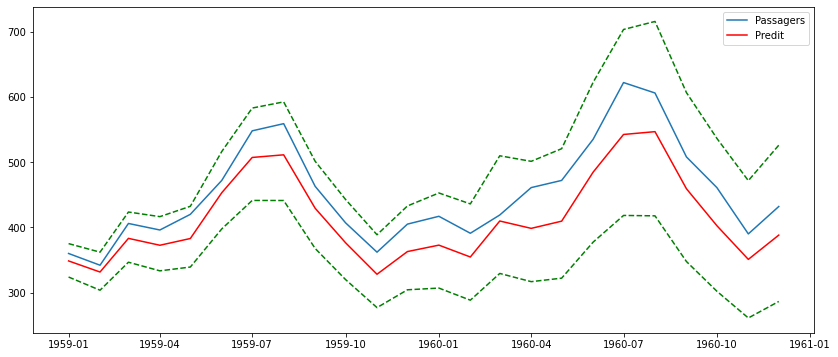

RMSE = 43.18161290119426 et MAPE = 8.515863968190489


In [43]:
x_train = x[:'1958']
x_test = x['1959':]
y_train = y[:'1958']
y_test = y['1959':]

# modélisation et summary
model = SARIMAX(y_train.values, order=(0,1,1), seasonal_order=(0,1,1,12))
res = model.fit()
print(res.summary())

# test d'autocorrélation des résidus
print('Retard : p-value')
for lag in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(lag, acorr_ljungbox(res.resid, lags=lag, return_df=False)[1].mean()))
    
# test de normalité des résidus
print(shapiro(res.resid[13:]))

# prédiction et intervalles de confiance
y_pred = res.get_forecast(len(y_test))
x_pred = np.exp(y_pred.predicted_mean)
x_pred_inf = [np.exp(p[0]) for p in y_pred.conf_int(alpha=0.05)]
x_pred_sup = [np.exp(p[1]) for p in y_pred.conf_int(alpha=0.05)]

# affichage
plt.figure(figsize=(14,6))
plt.plot(x_test.index, x_test.values, label='Passagers')
plt.plot(x_test.index, x_pred, color='r', label='Predit')
plt.plot(x_test.index, x_pred_inf, color='g', linestyle='--')
plt.plot(x_test.index, x_pred_sup, color='g', linestyle='--')
plt.legend()
plt.show()

# évaluation de la qualité de prédiction
rmse = np.sqrt(((x_test-x_pred)**2).mean())
mape = (np.abs(1-x_pred/x_test)).mean()*100
print("RMSE = {} et MAPE = {}".format(rmse, mape))

### Une autre approche pour la détermination du modèle

Pour adapter les données de série temporelles à un modèle ARIMA saisonnier avec les paramètres $SARIMA(p,d,q)(P,D,Q)s$, on doit trouver les paramètres optimaux et pour ça on peut aussi faire de la recherche sur grille qui consiste à tester de manière itérative plusieurs valeurs possibles des paramètres et d'évaluer les modèles en utilisant des critères comme le critère AIC ou BIC.

On utilisera nous le critère d'information Akaike ($AIC$) qui mesure la qualité relative des modèles statistiques pour un ensemble d'observations donné. À partir d'un ensemble de modèles, le critère $AIC$ permet d'estime la qualité de chacun des modèle par rapport aux autres modèles. Cela permet donc de sélectionner des modèles. Intuitivement, le critère $AIC$ mesure le compromis entre la qualité de l'ajustement du modèle aux observations fournies et la complexité du modèle (nombre de paramètres inclus et estimés). Le critère $AIC$ est calculé par :

$AIC=2k-2ln(L)$ avec :
- $k$ nombre de paramètres estimés
- $L$ valeur maximale de la vraisemblance (pour simplifier maximiser la vraisemblance revient plus ou moins à minimiser l'erreur)

Le meilleur modèle est celui qui minimise le critère $AIC$.

**Exo :** on continue à modéliser la série logarithmique. Tronquer la série en 1958 (inclus) pour prédire 1959 et 1960

In [47]:
x_train = x[:'1958']
x_test = x['1959':]
y_train = y[:'1958']
y_test = y['1959':]

**Exo :** générer les valeurs possibles des paramètres que nous aimerions évaluer, à savoir $(p,d,q)(P,D,Q)$ puisque $s$ sera égal à 12 on le sait. On testera toutes les valeurs entre 0 et 2 pour chacun des 6 paramètres c'est-à-dire $3^6 = 729$ possibilités, c'est long...

In [51]:
# on définit les valeurs possibles pour les paramètres
p = d = q = P = D = Q = range(3)

# on génère toutes les combinaisons possibles
import itertools
params = list(itertools.product(p, d, q, P, D, Q))
print(len(params), params[0:10])

729 [(0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 1), (0, 0, 0, 0, 0, 2), (0, 0, 0, 0, 1, 0), (0, 0, 0, 0, 1, 1), (0, 0, 0, 0, 1, 2), (0, 0, 0, 0, 2, 0), (0, 0, 0, 0, 2, 1), (0, 0, 0, 0, 2, 2), (0, 0, 0, 1, 0, 0)]


**Exo :** boucler sur toutes les combinaisons possibles de paramètres et calculer le critère AIC pour déterminer le meilleur modèle parmi ceux testés (la valeur du critère AIC d'un modèle est facilement récupérable...)

```python
from statsmodels.tsa.statespace.sarimax import *
import sys

import warnings
warnings.filterwarnings(action='ignore') #'once' pour afficher le warning une seule fois

# pour affichage d'une barre de progression
from ipywidgets import IntProgress
from IPython.display import display
progressbar = IntProgress(min=0, max=729) # instancie la barre de progression
display(progressbar) # affiche la barre

best_aic = np.inf
best_pdq = None
best_PDQ = None
tmp_model = None
best_model = None

for p,d,q,P,D,Q in params:
    try:
        tmp_model = SARIMAX(y_train,
                            order = (p,d,q),
                            seasonal_order = (P,D,Q,12),
                            enforce_stationarity=True,
                            enforce_invertibility=True)
        res = tmp_model.fit()
        
        progressbar.value += 1 #signal pour augmenter la barre de progression

        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = (p,d,q)
            best_PDQ = (P,D,Q)
            best_model = tmp_model
    except:
        #print("Erreur:", sys.exc_info()[1])
        continue
            
print("Modèle retenu : SARIMA{}{}12 - AIC:{}".format(best_pdq, best_PDQ, best_aic))
```

Le code ci-dessus permet de tester toutes les valeurs des paramètres et on obtient comme modèle optimal (c'est un peu long).  
output : Modèle retenu : SARIMA(0, 1, 1)(1, 0, 1)12 - AIC:-405.4220183264598

Les modèles retenus pour les différentes séries sont :
- pour la série originale tronquée `x_train`: $SARIMA(1, 1, 0)(0, 2, 2)12 / AIC:727.0352304108962$
- pour la série logarithmique tronquée `y_train`: $SARIMA(0, 1, 1)(1, 0, 1)12 / AIC:-405.4220183264598$
- pour la série originale complète `x`: $SARIMA(0, 1, 1)(0, 2, 2)12 / AIC:938.046448335865$
- pour la série logarithmique complète `y`: $SARIMA(0, 1, 1)(2, 0, 2)12 / AIC:-499.9919796568762$

**Exo :**
- entrainer le modèle retenu
- calculer l'AIC
- afficher le summary pour notamment vérifier les p-values des coefficients
- regarder les résidus

-405.4220183264598
                                     SARIMAX Results                                      
Dep. Variable:                            Airpass   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 206.711
Date:                            Tue, 09 Jun 2020   AIC                           -405.422
Time:                                    12:05:51   BIC                           -394.306
Sample:                                01-01-1949   HQIC                          -400.908
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2906      0.082     -3.543      0.000      -0.451      -0.130
ar.S.L12       0

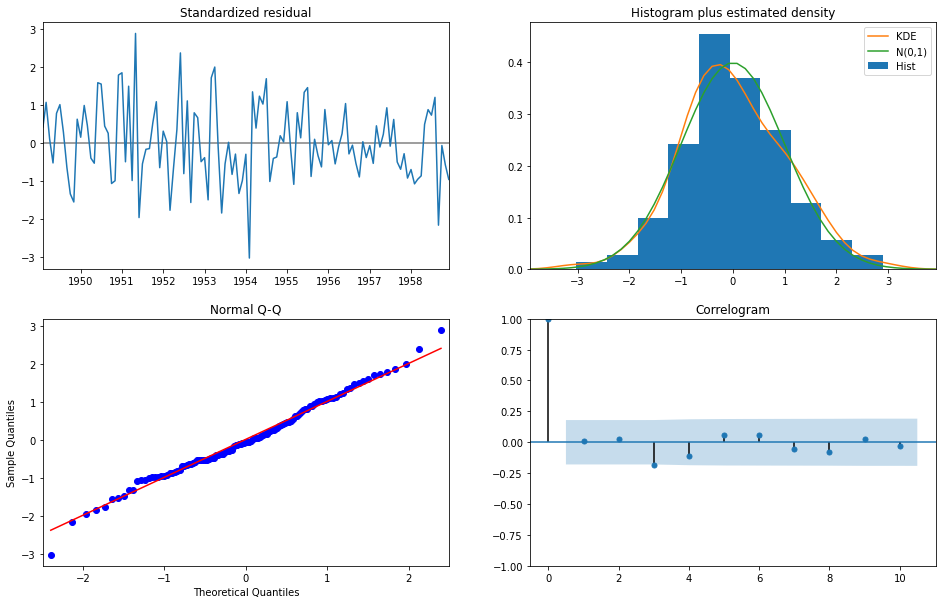

In [52]:
# modèle retenu
res = SARIMAX(y_train, order=(0,1,1), seasonal_order=(1,0,1,12)).fit()

# summary
print(res.aic)
print(res.summary())

# résidus
res.plot_diagnostics(figsize=(16, 10));
print("Test de Shapiro :", shapiro(res.resid[13:]))

**Exo :** prédire à partir du modèle retenu les 2 années 1959 et 1960 et afficher sur un même graphique la série originale, les prédictions et l'intervalle de confiance.

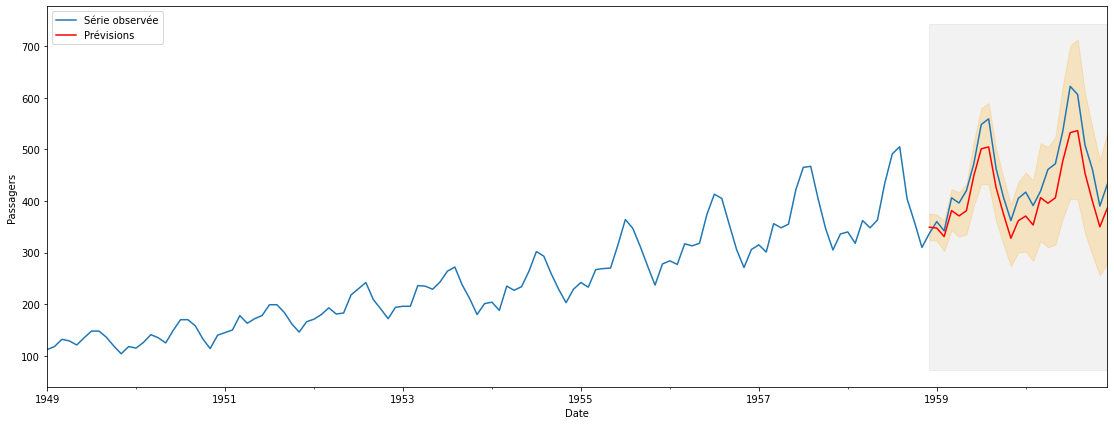

In [53]:
# prédiction et intervalles de confiance
y_pred = res.get_prediction(start=pd.to_datetime('1958-12-01'), end=pd.to_datetime('1960-12-01'))
x_pred = np.exp(y_pred.predicted_mean)
pred_CI = np.exp(y_pred.conf_int())

# affichage
fig = plt.figure(figsize=(19, 7))
ax = x['1949':].plot(label='Série observée');
x_pred.plot(ax=ax, label='Prévisions', color='red');

# affichage de l'intervalle de confiance
ax.fill_between(pred_CI.index, 
                pred_CI.iloc[:, 0], 
                pred_CI.iloc[:, 1], color='orange', alpha=.2);

# un peu de style
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), x.index[-1], alpha=.1, zorder=-1, color='grey');
ax.set_xlabel('Date');
ax.set_ylabel('Passagers');
plt.legend(loc='upper left');
plt.show()

**Exo :** évaluer la qualité prédictive du modèle via RMSE et MAPE.

In [54]:
rmse = np.sqrt(((x_test-x_pred)**2).mean())
mape = (np.abs(1-x_pred/x_test)).mean()*100
print("RMSE = {} et MAPE = {}".format(rmse, mape))

RMSE = 47.12950726638053 et MAPE = 9.223161554144866


**Exo :** faire une prévision à long terme  
À l'aide d'un processus ARIMA saisonnier basé sur toute la série temporelle (on modélise toujours la série logarithmique), prédire les 10 années suivantes : déterminer les paramètres du modèle optimal par recherche sur grille.  
Afficher les graphiques qui vous paraissent utiles et intéressants.

```python
from statsmodels.tsa.statespace.sarimax import *
import sys
import itertools
from ipywidgets import IntProgress
from IPython.display import display
import warnings
warnings.filterwarnings(action='ignore')

# valeurs possibles des paramètres
max_param = 3
p = d = q = P = D = Q = range(max_param)

# barre de progression
progressbar = IntProgress(min=0, max=max_param**6)
display(progressbar)

best_aic = np.inf
best_pdq = None
best_PDQ = None
tmp_model = None
best_model = None

for p,d,q,P,D,Q in itertools.product(p, d, q, P, D, Q):
    try:
        tmp_model = SARIMAX(y,
                            order = (p,d,q),
                            seasonal_order = (P,D,Q,12),
                            enforce_stationarity=True,
                            enforce_invertibility=True)
        res = tmp_model.fit()
        
        progressbar.value += 1 #signal pour augmenter la barre de progression

        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = (p,d,q)
            best_PDQ = (P,D,Q)
            best_model = tmp_model
    except:
        #print("Erreur:", sys.exc_info()[1])
        continue
            
print("Modèle retenu : SARIMA{}{}12 - AIC:{}".format(best_pdq, best_PDQ, best_aic))
```

-499.3159719562424
                                     SARIMAX Results                                      
Dep. Variable:                            Airpass   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 253.658
Date:                            Tue, 09 Jun 2020   AIC                           -499.316
Time:                                    12:08:45   BIC                           -487.465
Sample:                                01-01-1949   HQIC                          -494.500
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3549      0.070     -5.065      0.000      -0.492      -0.218
ar.S.L12       0

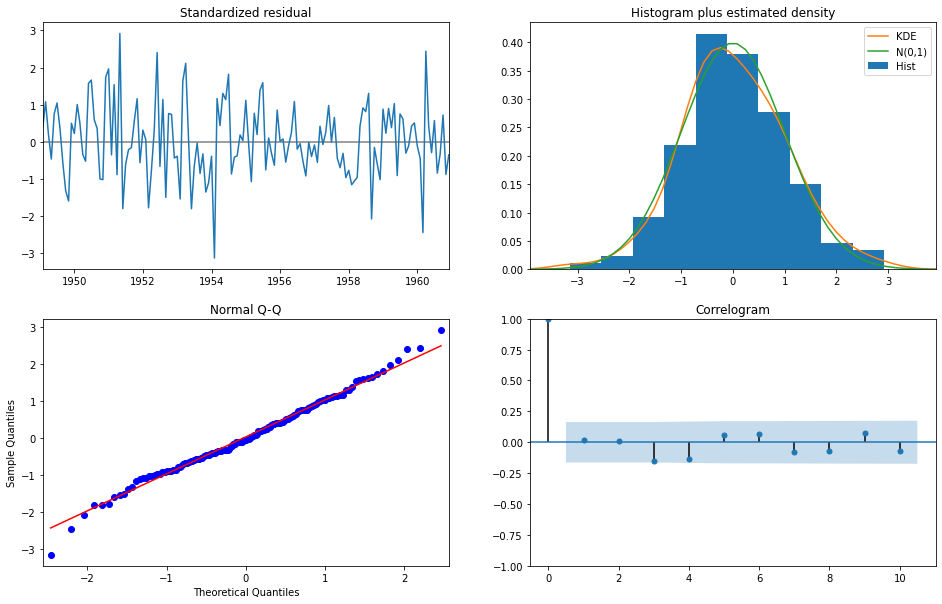

In [55]:
# modèle retenu
res = SARIMAX(y, order=(0,1,1), seasonal_order=(1,0,1,12)).fit()

# summary
print(res.aic)
print(res.summary())

# résidus
res.plot_diagnostics(figsize=(16, 10));
print("Test de Shapiro :", shapiro(res.resid[13:]))

# prédiction et intervalles de confiance
y_pred = res.get_forecast(steps=120)
x_pred = np.exp(y_pred.predicted_mean)
pred_CI = np.exp(y_pred.conf_int(alpha=0.05))

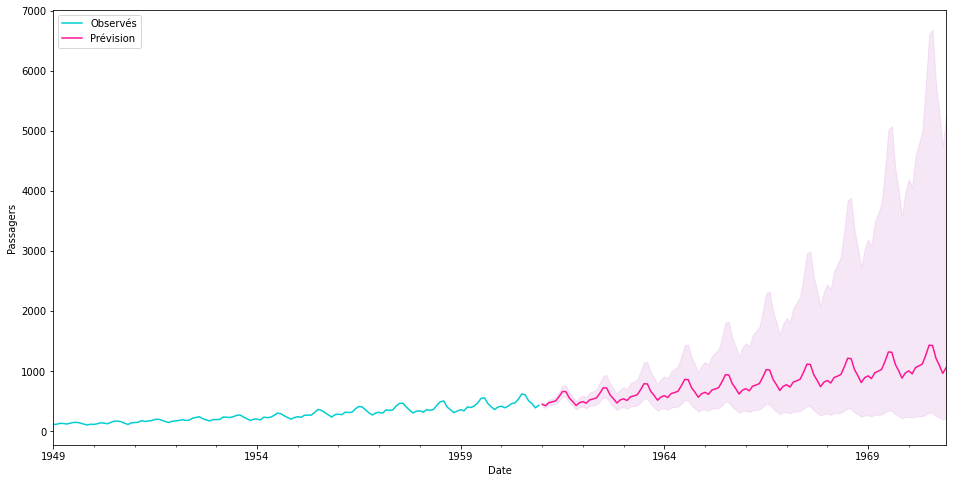

In [56]:
# affichage
ax = x.plot(label='Observés', figsize=(16, 8), color='darkturquoise');
x_pred.plot(ax=ax, label='Prévision', color='deeppink')
ax.fill_between(pred_CI.index,
                pred_CI.iloc[:, 0],
                pred_CI.iloc[:, 1], color='plum', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Passagers');
plt.legend(loc='upper left')
plt.show()

/home/elka/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                              Airpass   No. Observations:                  144
Model:             SARIMAX(2, 1, 3)x(1, 2, [1], 12)   Log Likelihood                -461.982
Date:                              Tue, 09 Jun 2020   AIC                            939.963
Time:                                      12:08:50   BIC                            962.196
Sample:                                  01-01-1949   HQIC                           948.992
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0387      0.125      0.310      0.756      -0.205       0.283
ar.L2         -0.79

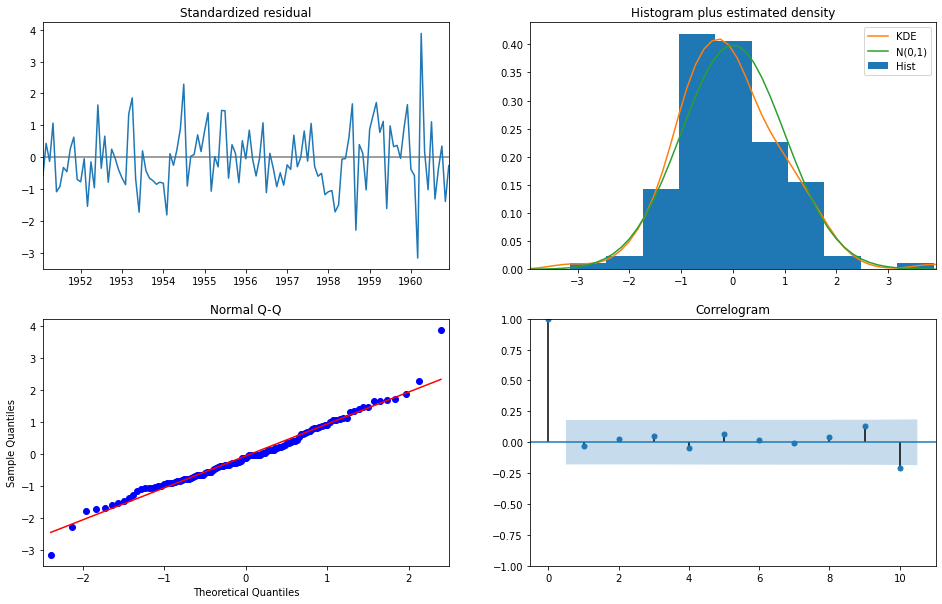

In [57]:
# modèle retenu
res = SARIMAX(x, order=(2,1,3), seasonal_order=(1,2,1,12)).fit()

# summary
print(res.summary())

# résidus
res.plot_diagnostics(figsize=(16, 10));
print("Test de Shapiro :", shapiro(res.resid[13:]))

# prédiction et intervalles de confiance
x_pred = res.get_forecast(steps=120)
pred_CI = x_pred.conf_int(alpha=0.05)

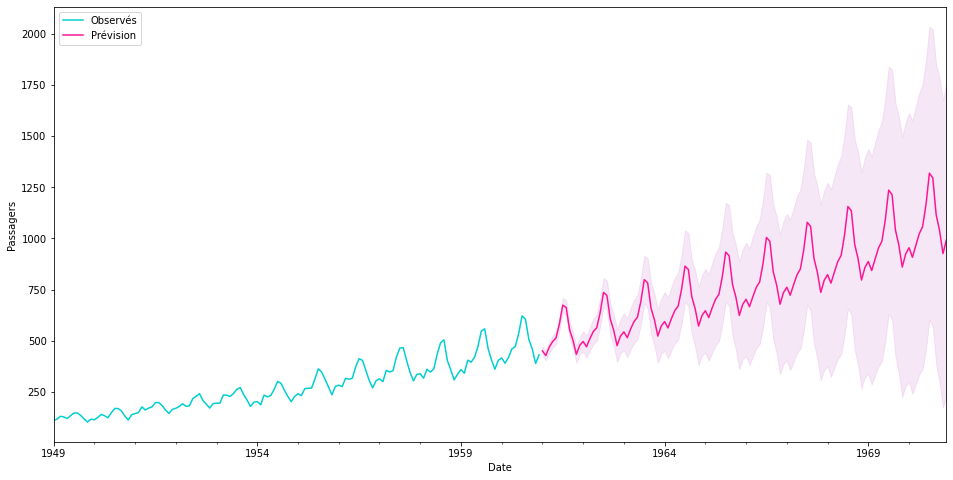

In [58]:
# affichage
ax = x.plot(label='Observés', figsize=(16, 8), color='darkturquoise');
x_pred.predicted_mean.plot(ax=ax, label='Prévision', color='deeppink')
ax.fill_between(pred_CI.index,
                pred_CI.iloc[:, 0],
                pred_CI.iloc[:, 1], color='plum', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Passagers');
plt.legend(loc='upper left')
plt.show()